### **<span style="color:#F7B2B0;">Give a thumbs up if you like this kernel</span>**



![](https://assets.newatlas.com/dims4/default/3bd8eb2/2147483647/strip/true/crop/7360x4912+0+0/resize/2880x1922!/quality/90/?url=http%3A%2F%2Fnewatlas-brightspot.s3.amazonaws.com%2F10%2F7f%2F5e48f79245c0b831a58d7cf8fb1d%2Fdepositphotos-228244172-xl.jpg)

In [1]:
# pip install --pre pycaret --quiet

# **<span style="color:#F7B2B0;">Importing Required Libraries</span>**



In [2]:
import pandas as pd
import numpy as np
from numpy import log1p
from scipy.special import boxcox1p 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics


import squarify 

plt.style.use('ggplot')
palette = sns.color_palette("YlOrBr", as_cmap=True)
# sns.light_palette("seagreen", as_cmap=True)
# Models
# from pycaret.classification import *


# **<span style="color:#F7B2B0;">REading DataFrame</span>**



In [3]:
df = pd.read_csv('/kaggle/input/predict-diabities/diabetes.csv')
df['unique_id'] = df.index

# **<span style="color:#F7B2B0;">Doing some basic checks on dataset</span>**



In [4]:
df.shape

(768, 10)

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
unique_id                   0
dtype: int64

In [6]:
# Looks like there are outliers in Insulin column 
description_df = df.describe()
description_df = description_df.style.background_gradient()
description_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,unique_id
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958,383.500000
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951,221.846794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000,191.750000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000,383.500000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000,575.250000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,767.000000


# **<span style="color:#F7B2B0;">Separating Feature & Target Columns</span>**



In [7]:
FEATURES = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
TARGET = ['Outcome']

IDENTIFIER = ['unique_id']

# **<span style="color:#F7B2B0;">Pie Chart for checking class imbalence</span>**



In [8]:
# Check Target for class imbalence 
target_dis = df[TARGET].value_counts().reset_index()
target_dis.columns = ['outcome','counts']
target_dis['outcome'] = target_dis['outcome'].map({0:'Diabetes Free',1:'Having Diabetes'})
px.pie(data_frame=target_dis, names='outcome', values='counts')

# **<span style="color:#F7B2B0;">Check for outliers</span>**
* It seems there is quite a number of outliers present in the data



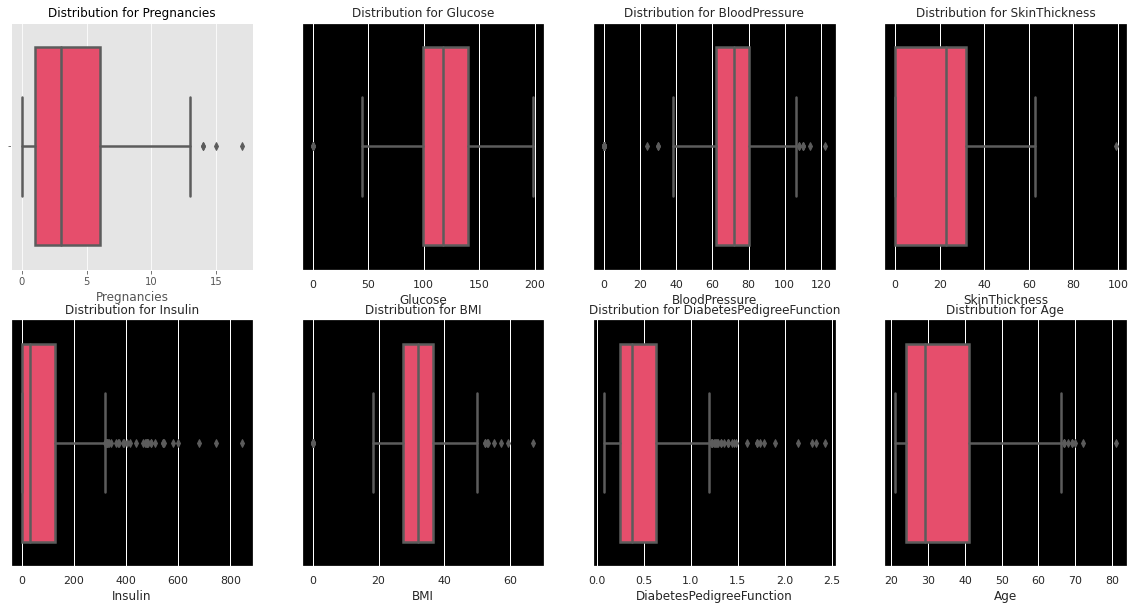

In [9]:
# Check Data Distribution and Outliers
def check_distribution_boxplot(data,feature_list):
    plt.figure(figsize=(20,10))
    for n,col in enumerate(feature_list):
        ax = plt.subplot(2, 4, n + 1)
        sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'lime',"lines.linewidth": 2.5})
        sns.boxplot(data=data, x=col,ax=ax,color = '#ff355d')
        ax.set_title(f'Distribution for {col}')
    plt.show()
check_distribution_boxplot(df,FEATURES)

# **<span style="color:#F7B2B0;">Check for skewness in the data</span>**
* Looks like few of the columns are quite skewed



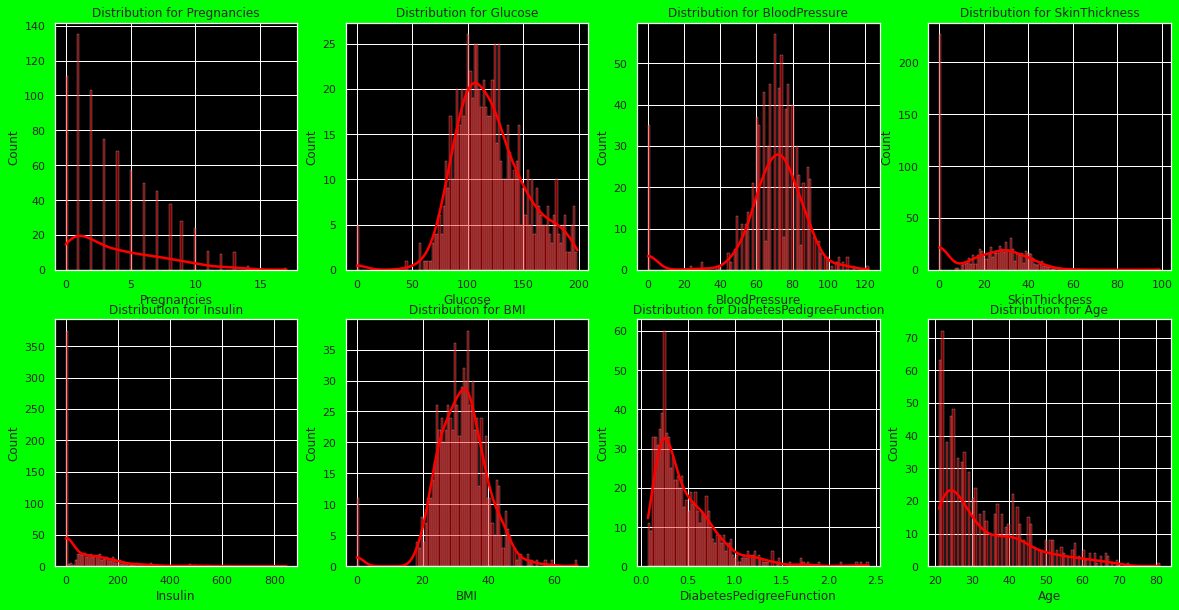

In [10]:
# Check Data Distribution for skewness
def check_distribution_dist(data,feature_list):
    plt.figure(figsize=(20,10))
    for n,col in enumerate(feature_list):
        ax = plt.subplot(2, 4, n + 1)
        sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'yellow',"lines.linewidth": 2.5})
        sns.histplot(data=data, x=col,ax=ax,kde=True,palette=palette, bins = 100,color='red')
        ax.set_title(f'Distribution for {col}')
    plt.show()
check_distribution_dist(df,FEATURES)

# **<span style="color:#F7B2B0;">Distribution check with KDE PLot</span>**



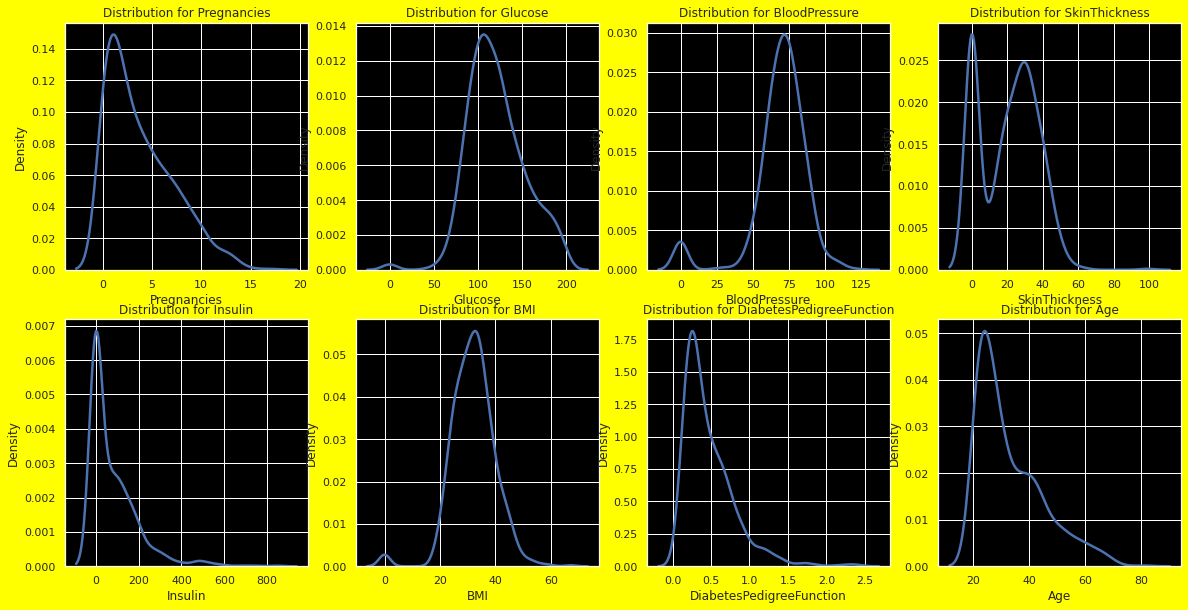

In [11]:
# Check Data Distribution for kernel density
def check_distribution_dist(data,feature_list):
    plt.figure(figsize=(20,10))
    for n,col in enumerate(feature_list):
        ax = plt.subplot(2, 4, n + 1)
        sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'DeepPink',"lines.linewidth": 2.5})
        sns.kdeplot(data=data, x=col,ax=ax)
        ax.set_title(f'Distribution for {col}')
    plt.show()
check_distribution_dist(df,FEATURES)

# **<span style="color:#F7B2B0;">Check for correlation between variables</span>**



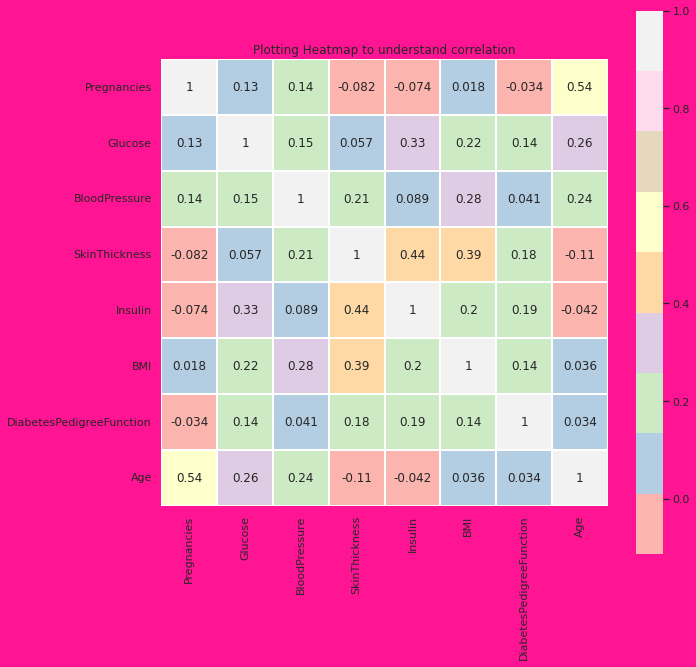

In [12]:
# Checking correlations 

def plot_heatmap(data,feature_list):
    plt.figure(figsize=(10,10))
    corr1 = data[feature_list].corr()
    matrix = np.triu(corr1)
    sns.heatmap(corr1,linewidths=0.1,vmax=1.0,square=True, cmap="Pastel1", linecolor='white', annot=True)
    plt.title('Plotting Heatmap to understand correlation')
    plt.show()

plot_heatmap(df,FEATURES)

# **<span style="color:#F7B2B0;">Check pair wise correlation</span>**



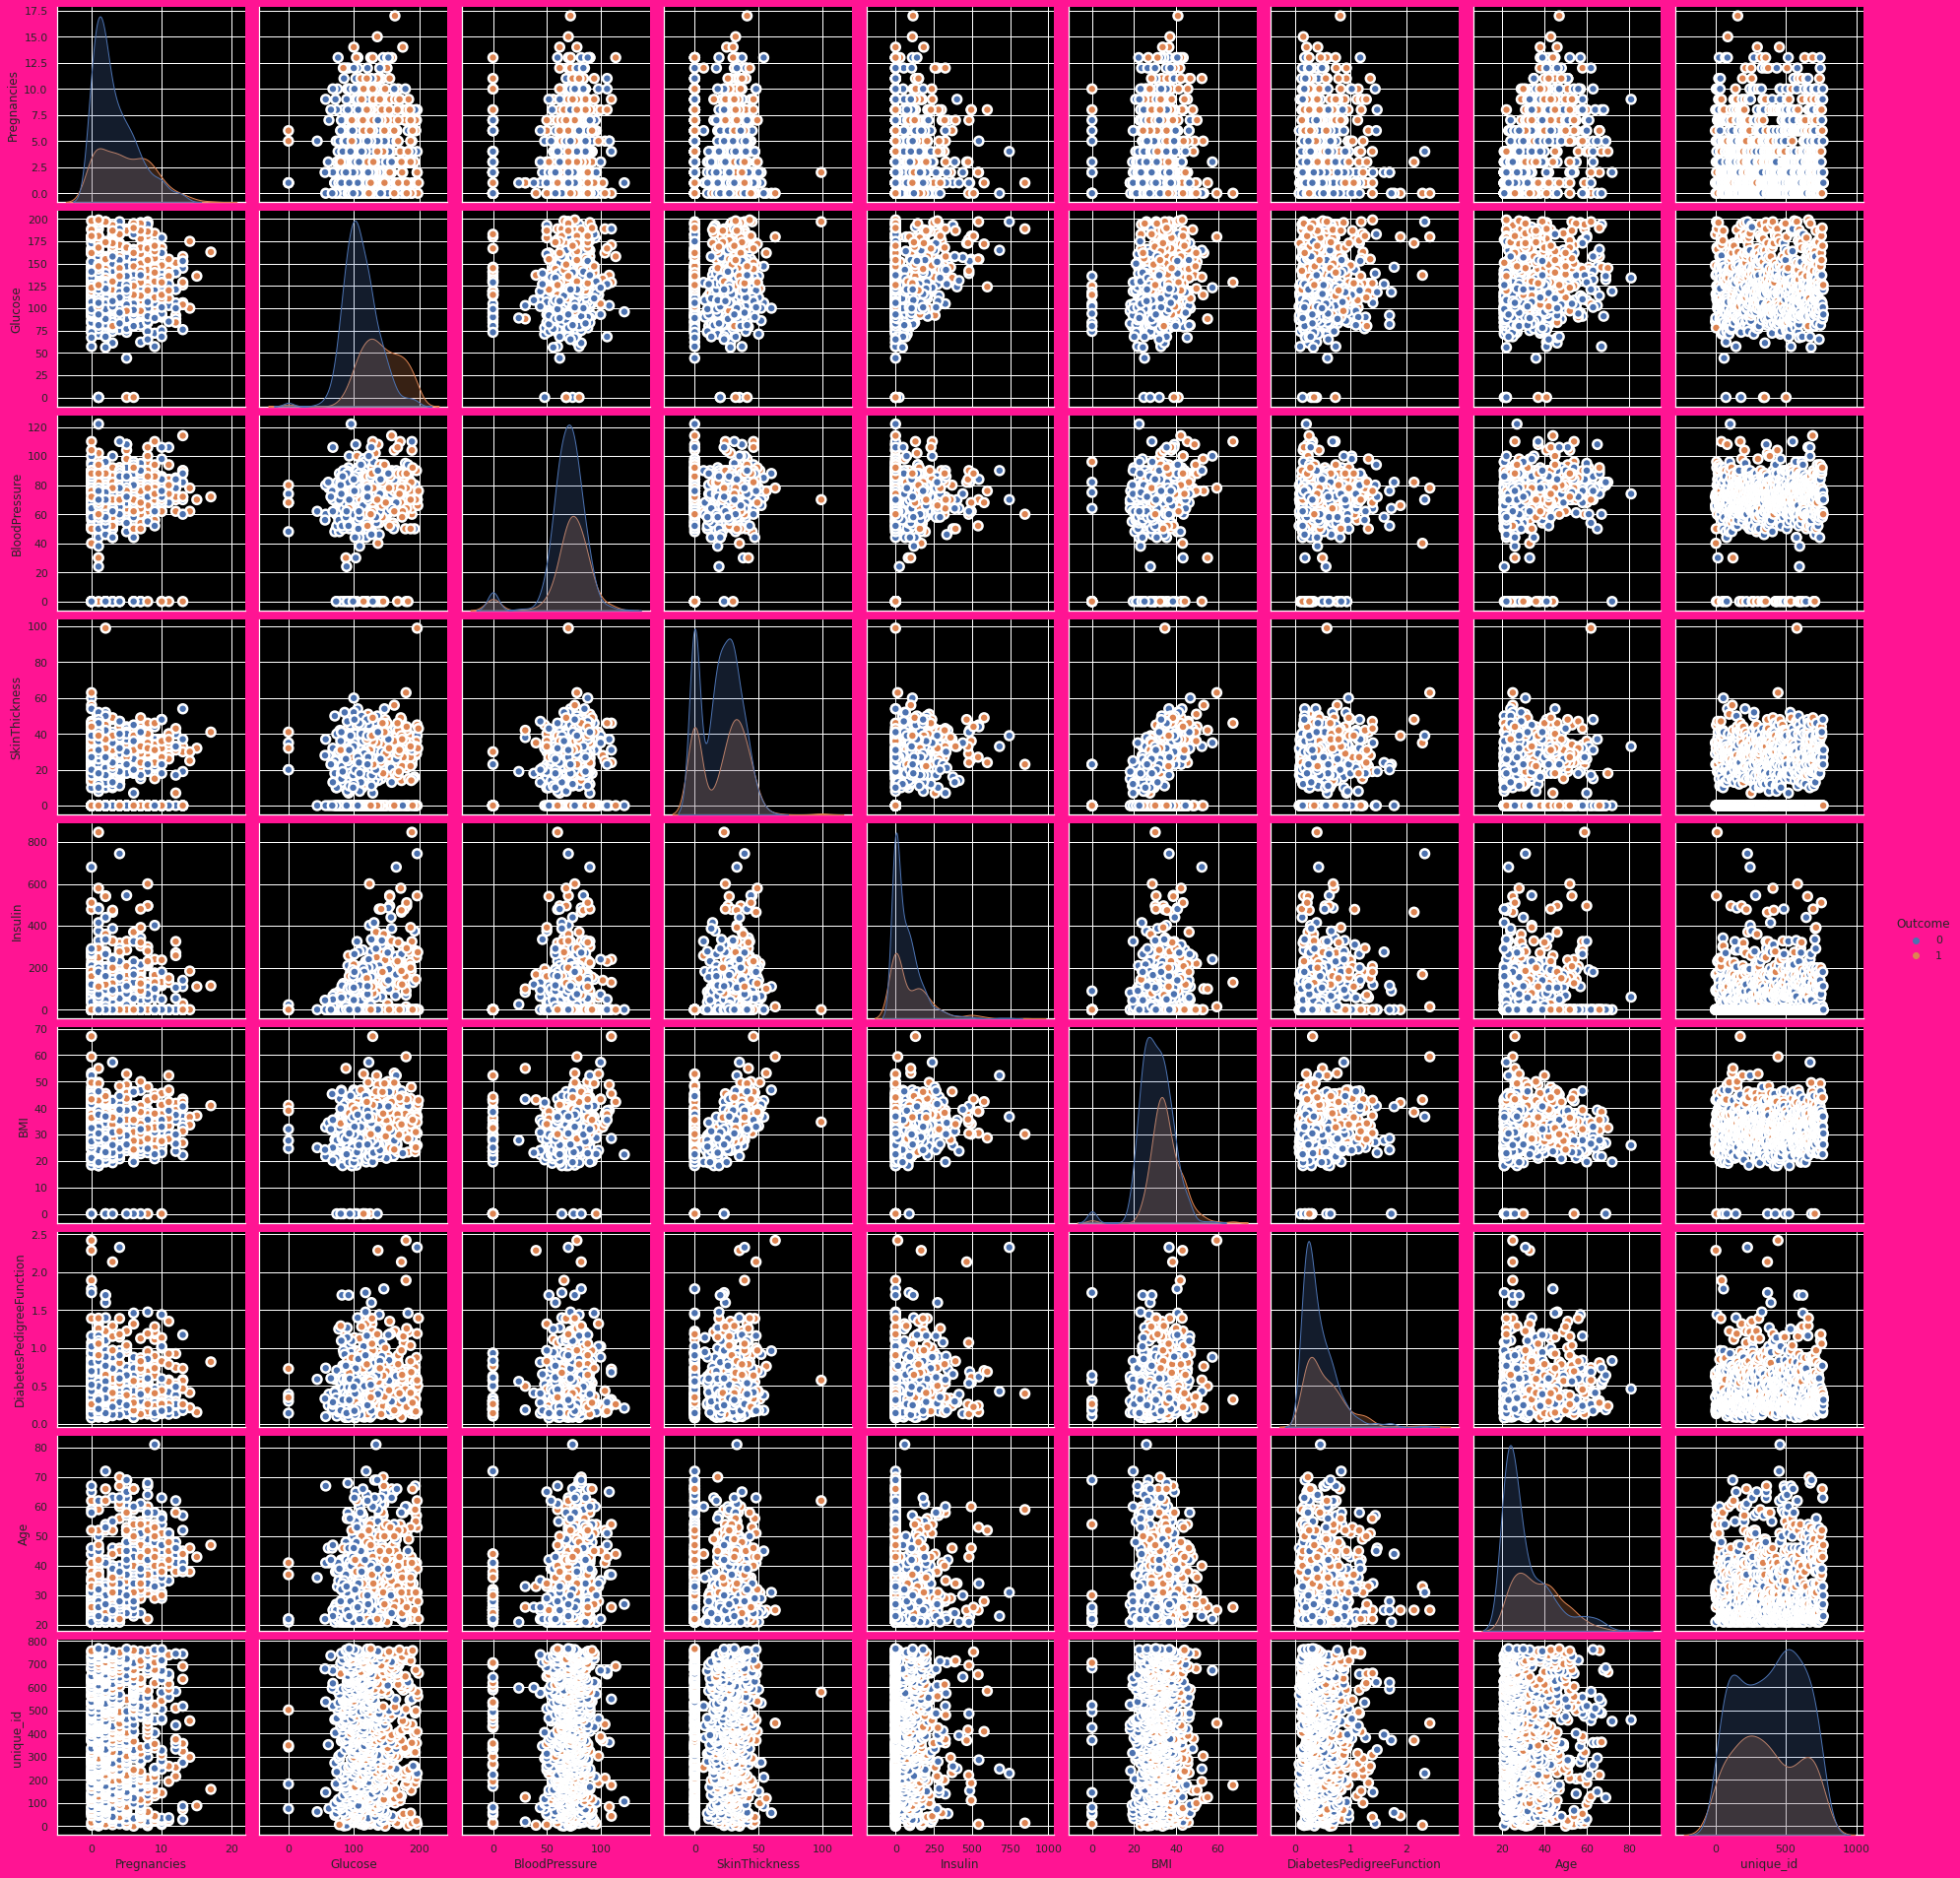

In [13]:
def plot_pairplot(data,feature_list):
    corr2 = data[feature_list].corr()
    sns.pairplot(df,height=3,kind="scatter",hue="Outcome",plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
    plt.show()
plot_pairplot(df,FEATURES)

# **<span style="color:#F7B2B0;">Check how diffrent features are contributing towards diabetic</span>**



In [14]:
# Mean values of features Having Diabetics
agg_values_with_tar = df.groupby(TARGET)[FEATURES].agg('mean').reset_index()
agg_values_with_tar = agg_values_with_tar.T
agg_values_with_tar = agg_values_with_tar.iloc[1:,:]
agg_values_with_tar.columns = ['Non Diabetic','Diabetic']
agg_values_with_tar.style.background_gradient()

,Non Diabetic,Diabetic
Pregnancies,3.298000,4.865672
Glucose,109.980000,141.257463
BloodPressure,68.184000,70.824627
SkinThickness,19.664000,22.164179
Insulin,68.792000,100.335821
BMI,30.304200,35.142537
DiabetesPedigreeFunction,0.429734,0.550500
Age,31.190000,37.067164


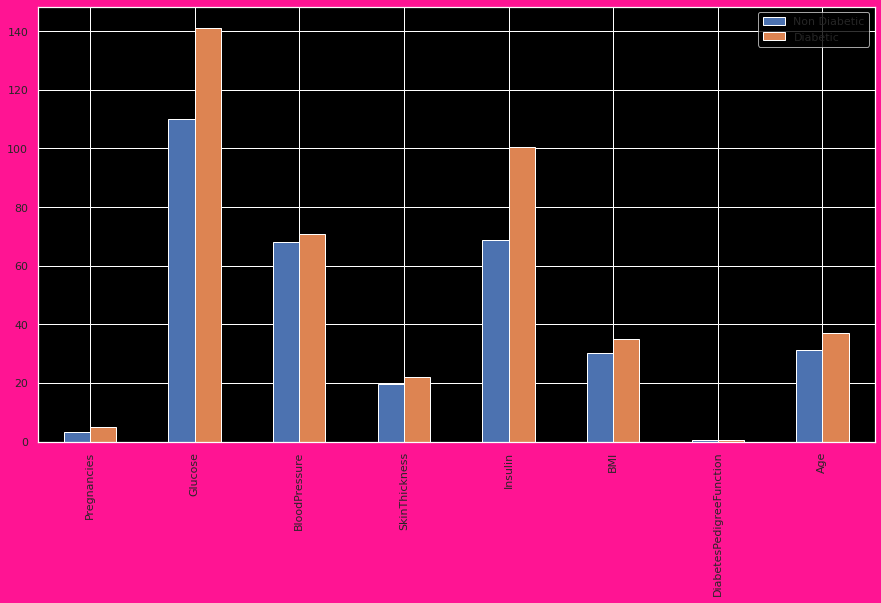

In [15]:
agg_values_with_tar.plot(kind='bar',figsize=(15,8))
plt.show()

# **<span style="color:#F7B2B0;">Check which age range is having more diabetic patient</span>**



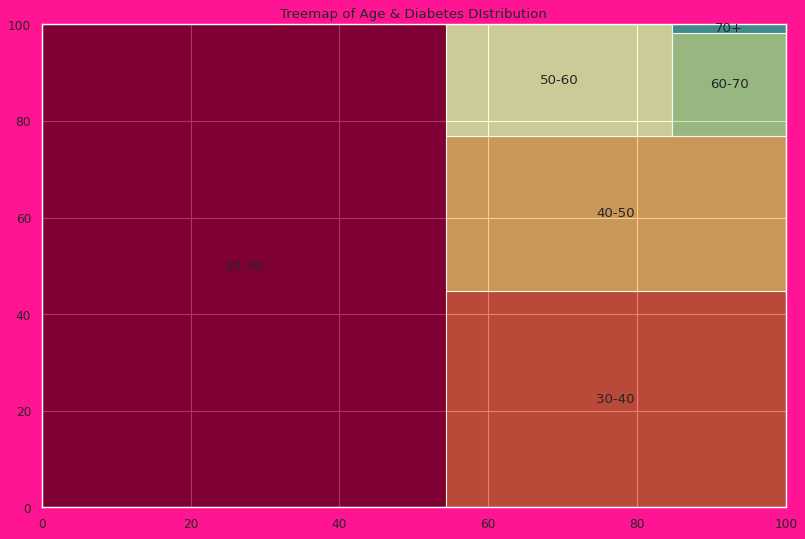

In [16]:
bins = [10, 30, 40, 50, 60, 70, 120]
labels = ['10-30', '30-40', '40-50', '50-60', '60-70', '70+']
df['age_bins'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
age_diabetes = df.groupby('age_bins')['Outcome'].count().reset_index()
age_diabetes.columns = ['age','counts']

colors = [plt.cm.Spectral(i/float(len(age_diabetes.age))) for i in range(len(age_diabetes.age))]
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=age_diabetes.counts, label=age_diabetes.age, color=colors, alpha=.8)
plt.title('Treemap of Age & Diabetes DIstribution')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



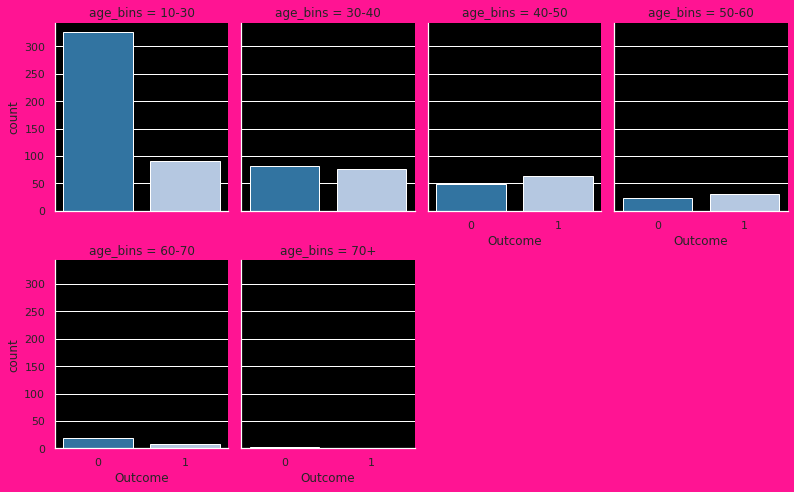

In [17]:
sns.catplot("Outcome", col="age_bins", col_wrap=4,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
plt.show()
df = df.drop('age_bins',axis=1)

# **<span style="color:#F7B2B0;">There is quite some Outlier in the data but as the dataset size is less i am not dropping those</span>**



In [18]:
def detect_outlier(df , column):
    
    global LOWER,UPPER
    
    Q25, Q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    IQR = Q75 - Q25
    CUT_OFF = IQR * 1.5
    LOWER, UPPER = Q25 - CUT_OFF, Q75 + CUT_OFF
    print('#####################################')
    print(f'For Column Name {column}')
    print('The IQR is',IQR)
    print('The LOWER bound value is', LOWER)
    print('The UPPER bound value is', UPPER)
    df1 = df[df[column] > UPPER]
    df2 = df[df[column] < LOWER]
    print('Total number of outliers are', df1.shape[0]+ df2.shape[0])
    print('#####################################')

In [19]:
for column in FEATURES:
    detect_outlier(df , column)

#####################################
For Column Name Pregnancies
The IQR is 5.0
The LOWER bound value is -6.5
The UPPER bound value is 13.5
Total number of outliers are 4
#####################################
#####################################
For Column Name Glucose
The IQR is 41.25
The LOWER bound value is 37.125
The UPPER bound value is 202.125
Total number of outliers are 5
#####################################
#####################################
For Column Name BloodPressure
The IQR is 18.0
The LOWER bound value is 35.0
The UPPER bound value is 107.0
Total number of outliers are 45
#####################################
#####################################
For Column Name SkinThickness
The IQR is 32.0
The LOWER bound value is -48.0
The UPPER bound value is 80.0
Total number of outliers are 1
#####################################
#####################################
For Column Name Insulin
The IQR is 127.25
The LOWER bound value is -190.875
The UPPER bound value is 318.125
T

# **<span style="color:#F7B2B0;">Creating a Train & Holdout set</span>**


In [20]:
# Variables
SEED = 2002
SPLITS = 5

In [21]:
train_df,holdout_df = model_selection.train_test_split(df,test_size=0.3,random_state=SEED)

# **<span style="color:#F7B2B0;">Making the Distribution Normal Using Log transformation</span>**

In [22]:
# From KDE plot we can notice below columns are having distribution issue they are skewed
SKEWED_COLUMNS = ['Pregnancies','SkinThickness','Insulin','DiabetesPedigreeFunction','Age']
def make_normal_distribution(df,feature_list):
    df[SKEWED_COLUMNS] = np.log1p(df[SKEWED_COLUMNS])
    return df

SCALE_COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

scaler = preprocessing.StandardScaler()
def scale_data(scaler,train_df,val_df,feature_list):
    train_df[feature_list] = scaler.fit_transform(train_df[feature_list])
    val_df[feature_list] = scaler.transform(val_df[feature_list])
    return train_df,val_df
    

train_df = make_normal_distribution(train_df,SKEWED_COLUMNS)
holdout_df = make_normal_distribution(holdout_df,SKEWED_COLUMNS)

train_df,holdout_df = scale_data(scaler,train_df,holdout_df,SCALE_COLUMNS)

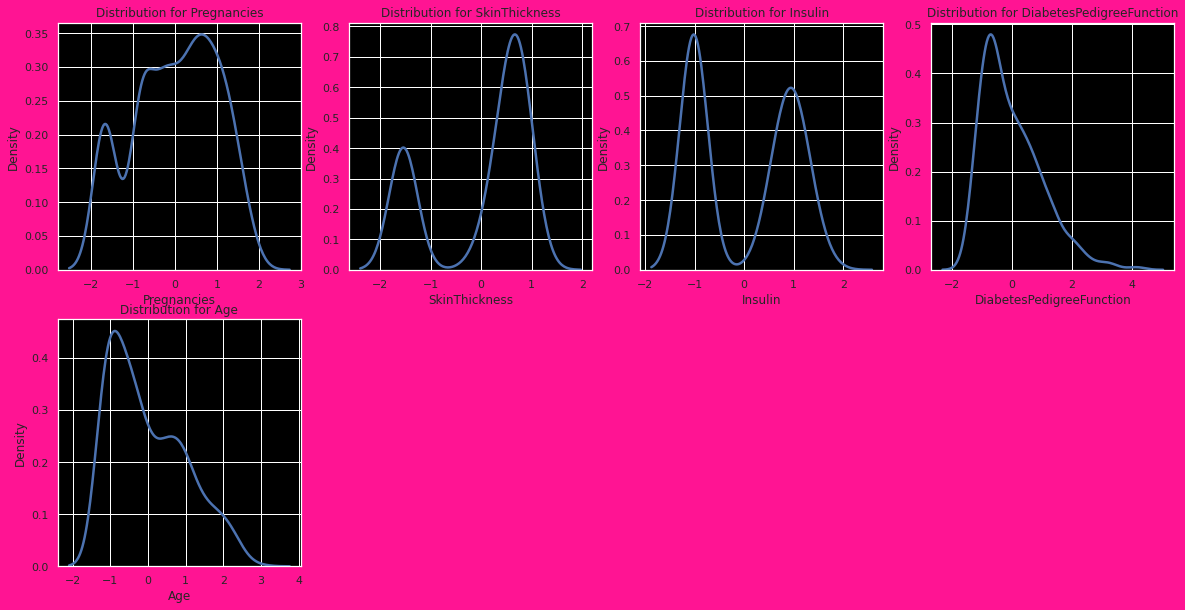

In [23]:
check_distribution_dist(train_df,SKEWED_COLUMNS)

# **<span style="color:#F7B2B0;">Using Pycaret For Model Selection</span>**


In [24]:
# clf_caret = setup(data = train_df, 
#              target = 'Outcome')

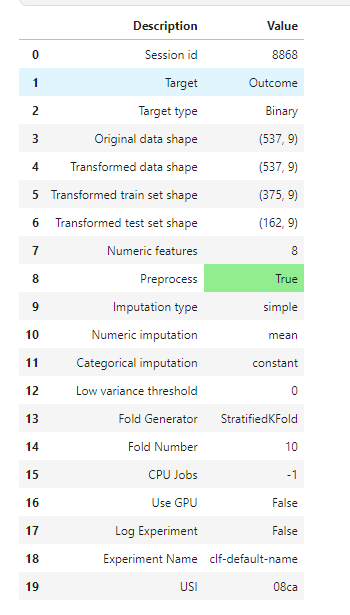

In [25]:
# compare_models()

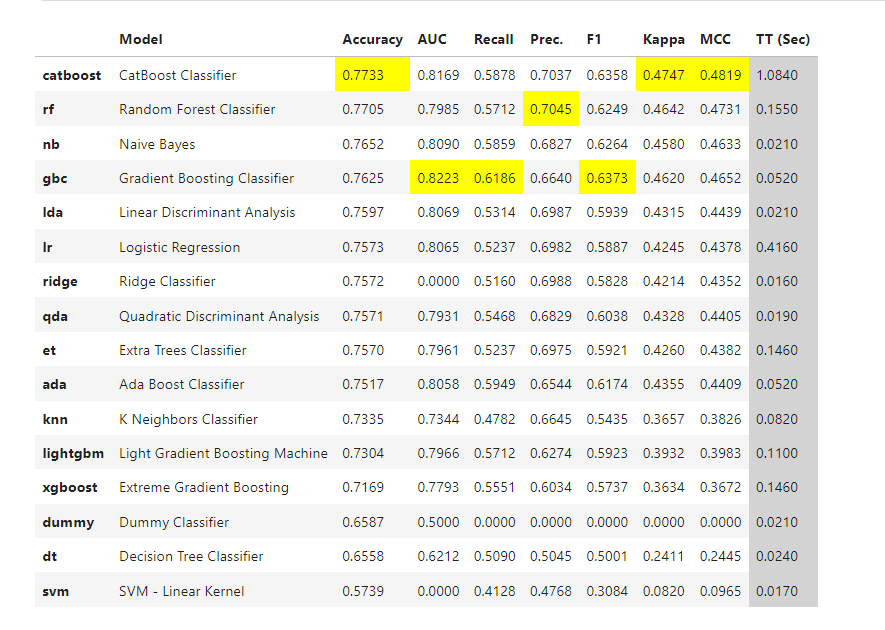

# **<span style="color:#F7B2B0;">Create Cross Validation Dataset for Traing Data</span>**


In [26]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df['kfold'] = -999
y = train_df.Outcome

skf = model_selection.StratifiedKFold(n_splits=SPLITS,shuffle=True, random_state=SEED)

for fold,(tidx,vidx) in enumerate(skf.split(X = train_df,y=y)):
    train_df.loc[vidx,'kfold'] =fold 
    
train_df.to_csv('train_df_fold.csv',index=False)

In [27]:
train_data = pd.read_csv('/kaggle/working/train_df_fold.csv')

# **<span style="color:#F7B2B0;">Selecting Top 5 Models Based On AUC</span>**


In [28]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from  catboost import CatBoostClassifier

# **<span style="color:#F7B2B0;">Create OOF Files for all these models</span>**


In [29]:
def run(model,train_data,holdout_data,fold):
    
    train_d = train_data.query("kfold!=@fold").reset_index(drop=True)
    val_d = train_data.query("kfold==@fold").reset_index(drop=True)
    train_id = train_d[IDENTIFIER]
    val_id = val_d[IDENTIFIER]
    
    train_X = train_d[FEATURES]
    train_y = train_d[TARGET].values.ravel()
    
    val_X = val_d[FEATURES]
    val_y = val_d[TARGET].values.ravel()
    
    test_X = holdout_data[FEATURES]
    
    model.fit(train_X,train_y)
    
    val_pred = model.predict_proba(val_X)[:,1]
    test_pred = model.predict_proba(test_X)[:,1]
    
    val_auc = metrics.roc_auc_score(val_y,val_pred)
    
    print(f'For Fold{fold} AUC={val_auc}')  
    
    return val_id,val_y,val_pred,np.ones_like(val_pred,dtype='int8')*fold,test_pred

# **<span style="color:#F7B2B0;">Instansiate Models</span>**


In [30]:
model_1 = RandomForestClassifier()
model_2 = LogisticRegression()
model_3 = GaussianNB()
model_4 = GradientBoostingClassifier()
model_5 = CatBoostClassifier(silent=True)

# **<span style="color:#F7B2B0;">Model_1</span>**


In [31]:
oof_id = []
oof_tar=[]
oof_pred=[]
oof_fold = []
oof_sub = []
for f in range(0,5):
    val_id,val_y,val_pred,fold,test_pred = run(model_1,train_data,holdout_df,f)
    oof_id.append(val_id)
    oof_tar.append(val_y)
    oof_pred.append(val_pred)
    oof_fold.append(fold)
    oof_sub.append(test_pred)
    
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_id).reshape(-1,); folds = np.concatenate(oof_fold)
auc = metrics.roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

df_oof = pd.DataFrame(dict(
    id = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof_1.csv',index=False)
print(df_oof.head())

# Create Submission OOF
test_ids = holdout_df[IDENTIFIER].values.reshape(-1,)
test_score = np.mean(np.column_stack(oof_sub),axis=1)
sub_oof = pd.DataFrame(dict(
    id = test_ids, target=test_score))
sub_oof.to_csv('sub_1.csv',index=False)
print(sub_oof.head())

For Fold0 AUC=0.8372668443090979
For Fold1 AUC=0.8427864484202513
For Fold2 AUC=0.7769953051643192
For Fold3 AUC=0.8285714285714285
For Fold4 AUC=0.7415057915057915
Overall OOF AUC with TTA = 0.801
    id  target  pred  fold
0  378       1  0.82     0
1  258       0  0.40     0
2  425       1  0.70     0
3  323       1  0.34     0
4  224       0  0.05     0
    id  target
0  708   0.710
1  616   0.440
2  501   0.112
3  522   0.182
4  196   0.008


# **<span style="color:#F7B2B0;">Model_2</span>**


In [32]:
oof_id = []
oof_tar=[]
oof_pred=[]
oof_fold = []
oof_sub = []
for f in range(0,5):
    val_id,val_y,val_pred,fold,test_pred = run(model_2,train_data,holdout_df,f)
    oof_id.append(val_id)
    oof_tar.append(val_y)
    oof_pred.append(val_pred)
    oof_fold.append(fold)
    oof_sub.append(test_pred)
    
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_id).reshape(-1,); folds = np.concatenate(oof_fold)
auc = metrics.roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

df_oof = pd.DataFrame(dict(
    id = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof_2.csv',index=False)
print(df_oof.head())

# Create Submission OOF
test_ids = holdout_df[IDENTIFIER].values.reshape(-1,)
test_score = np.mean(np.column_stack(oof_sub),axis=1)
sub_oof = pd.DataFrame(dict(
    id = test_ids, target=test_score))
sub_oof.to_csv('sub_2.csv',index=False)
print(sub_oof.head())

For Fold0 AUC=0.7936810049486106
For Fold1 AUC=0.8203273696231443
For Fold2 AUC=0.78716744913928
For Fold3 AUC=0.7841698841698841
For Fold4 AUC=0.7806949806949807
Overall OOF AUC with TTA = 0.795
    id  target      pred  fold
0  378       1  0.809428     0
1  258       0  0.616781     0
2  425       1  0.746376     0
3  323       1  0.554584     0
4  224       0  0.078947     0
    id    target
0  708  0.683720
1  616  0.158475
2  501  0.179774
3  522  0.052920
4  196  0.068657


# **<span style="color:#F7B2B0;">Model_3</span>**


In [33]:
oof_id = []
oof_tar=[]
oof_pred=[]
oof_fold = []
oof_sub = []
for f in range(0,5):
    val_id,val_y,val_pred,fold,test_pred = run(model_3,train_data,holdout_df,f)
    oof_id.append(val_id)
    oof_tar.append(val_y)
    oof_pred.append(val_pred)
    oof_fold.append(fold)
    oof_sub.append(test_pred)
    
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_id).reshape(-1,); folds = np.concatenate(oof_fold)
auc = metrics.roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

df_oof = pd.DataFrame(dict(
    id = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof_3.csv',index=False)
print(df_oof.head())

# Create Submission OOF
test_ids = holdout_df[IDENTIFIER].values.reshape(-1,)
test_score = np.mean(np.column_stack(oof_sub),axis=1)
sub_oof = pd.DataFrame(dict(
    id = test_ids, target=test_score))
sub_oof.to_csv('sub_3.csv',index=False)
print(sub_oof.head())

For Fold0 AUC=0.8070041872858775
For Fold1 AUC=0.8058622002283974
For Fold2 AUC=0.784037558685446
For Fold3 AUC=0.796911196911197
For Fold4 AUC=0.7393822393822393
Overall OOF AUC with TTA = 0.789
    id  target      pred  fold
0  378       1  0.772058     0
1  258       0  0.814030     0
2  425       1  0.920303     0
3  323       1  0.771379     0
4  224       0  0.044511     0
    id    target
0  708  0.855819
1  616  0.274019
2  501  0.117140
3  522  0.045600
4  196  0.028448


# **<span style="color:#F7B2B0;">Model_4</span>**


In [34]:
oof_id = []
oof_tar=[]
oof_pred=[]
oof_fold = []
oof_sub = []
for f in range(0,5):
    val_id,val_y,val_pred,fold,test_pred = run(model_4,train_data,holdout_df,f)
    oof_id.append(val_id)
    oof_tar.append(val_y)
    oof_pred.append(val_pred)
    oof_fold.append(fold)
    oof_sub.append(test_pred)
    
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_id).reshape(-1,); folds = np.concatenate(oof_fold)
auc = metrics.roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

df_oof = pd.DataFrame(dict(
    id = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof_4.csv',index=False)
print(df_oof.head())

# Create Submission OOF
test_ids = holdout_df[IDENTIFIER].values.reshape(-1,)
test_score = np.mean(np.column_stack(oof_sub),axis=1)
sub_oof = pd.DataFrame(dict(
    id = test_ids, target=test_score))
sub_oof.to_csv('sub_4.csv',index=False)
print(sub_oof.head())

For Fold0 AUC=0.8382185001903312
For Fold1 AUC=0.8363151884278646
For Fold2 AUC=0.7715179968701096
For Fold3 AUC=0.8200772200772201
For Fold4 AUC=0.7451737451737452
Overall OOF AUC with TTA = 0.802
    id  target      pred  fold
0  378       1  0.775914     0
1  258       0  0.609694     0
2  425       1  0.875188     0
3  323       1  0.298287     0
4  224       0  0.067723     0
    id    target
0  708  0.795845
1  616  0.257708
2  501  0.043905
3  522  0.106202
4  196  0.023856


# **<span style="color:#F7B2B0;">Model_5</span>**


In [35]:
oof_id = []
oof_tar=[]
oof_pred=[]
oof_fold = []
oof_sub = []
for f in range(0,5):
    val_id,val_y,val_pred,fold,test_pred = run(model_5,train_data,holdout_df,f)
    oof_id.append(val_id)
    oof_tar.append(val_y)
    oof_pred.append(val_pred)
    oof_fold.append(fold)
    oof_sub.append(test_pred)
    
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_id).reshape(-1,); folds = np.concatenate(oof_fold)
auc = metrics.roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

df_oof = pd.DataFrame(dict(
    id = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof_5.csv',index=False)
print(df_oof.head())

# Create Submission OOF
test_ids = holdout_df[IDENTIFIER].values.reshape(-1,)
test_score = np.mean(np.column_stack(oof_sub),axis=1)
sub_oof = pd.DataFrame(dict(
    id = test_ids, target=test_score))
sub_oof.to_csv('sub_5.csv',index=False)
print(sub_oof.head())

For Fold0 AUC=0.8424057860677578
For Fold1 AUC=0.8503996954701181
For Fold2 AUC=0.77660406885759
For Fold3 AUC=0.8239382239382239
For Fold4 AUC=0.7517374517374518
Overall OOF AUC with TTA = 0.803
    id  target      pred  fold
0  378       1  0.786798     0
1  258       0  0.519694     0
2  425       1  0.813384     0
3  323       1  0.435277     0
4  224       0  0.034555     0
    id    target
0  708  0.709054
1  616  0.310176
2  501  0.089983
3  522  0.123732
4  196  0.015061


# **<span style="color:#F7B2B0;">I am New To Below Approach hill climbing (or forward selection), Taken Idea from below notebook </span>**
* https://www.kaggle.com/code/cdeotte/forward-selection-oof-ensemble-0-942-private/notebook

In [36]:
PATH = '/kaggle/working/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if 'oof' in f] )
OOF_CSV = [pd.read_csv(PATH+k) for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 5 oof files...

['oof_1.csv' 'oof_2.csv' 'oof_3.csv' 'oof_4.csv' 'oof_5.csv']


In [37]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].pred.values
    
TRUE = OOF_CSV[0].target.values

In [38]:
all = []
for k in range(x.shape[1]):
    auc = metrics.roc_auc_score(OOF_CSV[0].target,x[:,k])
    all.append(auc)
    print('Model %i has OOF AUC = %.4f'%(k,auc))
    
m = [np.argmax(all)]; w = []

Model 0 has OOF AUC = 0.8011
Model 1 has OOF AUC = 0.7947
Model 2 has OOF AUC = 0.7894
Model 3 has OOF AUC = 0.8017
Model 4 has OOF AUC = 0.8028


In [39]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble AUC = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 0; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 0; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = metrics.roc_auc_score(TRUE,tmp)
            if auc>bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst>mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = mx-old
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)


Ensemble AUC = 0.8028 by beginning with model 4

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 
Ensemble AUC = 0.8085 after adding model 1 with weight 0.265. Increase of 0.0057

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 
Ensemble AUC = 0.8109 after adding model 3 with weight 0.155. Increase of 0.0023

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 
Ensemble AUC = 0.8113 after adding model 2 with weight 0.060. Increase of 0.0004

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 
No increase. Stopping.


In [40]:
print('We are using models',m)
print('with weights',w)
print('and achieve ensemble AUC = %.4f'%old)

We are using models [4, 1, 3, 2]
with weights [0.265, 0.155, 0.06]
and achieve ensemble AUC = 0.8113


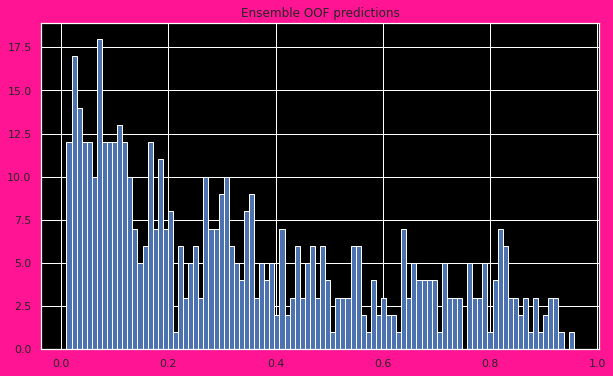

In [41]:
plt.figure(figsize=(10,6))
md = x[:,m[0]]
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md
plt.hist(md,bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [42]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof.csv',index=False)

In [43]:
SUB = np.sort( [f for f in FILES if 'sub' in f] )
SUB_CSV = [pd.read_csv(PATH+k) for k in SUB]

print('We have %i submission files...'%len(SUB))
print(); print(SUB)

We have 5 submission files...

['sub_1.csv' 'sub_2.csv' 'sub_3.csv' 'sub_4.csv' 'sub_5.csv']


In [44]:
# VERFIY THAT SUBMISSION FILES MATCH OOF FILES
a = np.array( [ int( x.split('_')[1].split('.')[0]) for x in SUB ] )
b = np.array( [ int( x.split('_')[1].split('.')[0]) for x in OOF ] )
if len(a)!=len(b):
    print('ERROR submission files dont match oof files')
else:
    for k in range(len(a)):
        if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [45]:
y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
for k in range(len(SUB)):
    y[:,k] = SUB_CSV[k].target.values

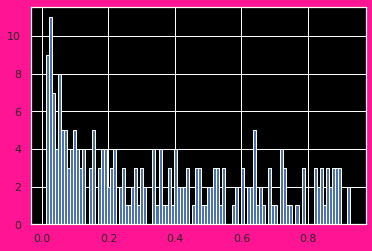

In [46]:
md2 = y[:,m[0]]
for i,k in enumerate(m[1:]):
    md2 = w[i]*y[:,k] + (1-w[i])*md2
plt.hist(md2,bins=100)
plt.show()

In [47]:
df = SUB_CSV[0].copy()
df.target = md2
df.to_csv('ensemble_sub.csv',index=False)

# **<span style="color:#F7B2B0;">----END---- </span>**